In [1]:
!pip -q install pandas numpy matplotlib seaborn

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [3]:
train = pd.read_csv('Train.csv')
train.tail()

,impressions,clicks,cost,conversions,ad_type,currency,ID,date,call_type,call_status,start_time,duration,end_time,display_location,impression_share,conversions_calls,headline1_len,headline2_len,ad_description_len
289921,NaN,NaN,NaN,NaN,NaN,NaN,ID_65687e2b40ea026fcc662a75,2024-02-03,NaN,NaN,NaN,NaN,NaN,NaN,12.035682,0.0,NaN,NaN,NaN
289922,NaN,NaN,NaN,NaN,NaN,NaN,ID_65687e2b40ea026fcc662a75,2024-02-04,NaN,NaN,NaN,NaN,NaN,NaN,15.711023,0.0,NaN,NaN,NaN
289923,NaN,NaN,NaN,NaN,NaN,NaN,ID_65a7bf329fa4627faf28390c,2024-02-03,NaN,NaN,NaN,NaN,NaN,NaN,15.464425,0.0,NaN,NaN,NaN
289924,NaN,NaN,NaN,NaN,NaN,NaN,ID_65b0f65c7fe62e56c5593d55,2024-02-03,NaN,NaN,NaN,NaN,NaN,NaN,10.016481,0.0,NaN,NaN,NaN
289925,NaN,NaN,NaN,NaN,NaN,NaN,ID_65b0f65c7fe62e56c5593d55,2024-02-04,NaN,NaN,NaN,NaN,NaN,NaN,9.990000,0.0,NaN,NaN,NaN


In [4]:
# We are going to create a test file out of our dataset
test = train.sample(frac=0.2, random_state=42) # We have split the data into 80% training and 20% testing
test.to_csv('Test.csv', index=False)

# We need to remove the test data from the training data
train = train.drop(test.index)
train.to_csv('train.csv', index=False)

## Background of the challenge
==========================
In a digital ecosystem saturated with advertisements, accurately predicting success is pivotal for businesses. Adbot aims to empower its small business clients with actionable insights to refine their ad campaigns and bolster customer engagement.

The objective of this challenge is to * accurately predict the number of clicks a client’s ad receives, one and two weeks into the future (in digital marketing, clicks refer to when someone views the advert and follows one of the hyperlinks in that advert) *. Winning solutions will further be required to submit a description of the variables that had the most significant impact on engagement (number of clicks). It is therefore important that the models you build are not only accurate, but also interpretable.

Solving this problem holds immense potential for the small African businesses leveraging the Adbot platform. Accurate ad impression and click-through-rate forecasting can revolutionise marketing strategies, enabling businesses to allocate resources effectively and maximise ad campaign ROI. By providing actionable insights, Adbot empowers clients to optimise their advertising efforts, improving customer engagement and driving business growth.

## EDA

In [5]:
# Check for features and samples
print(f"The dataset has {train.shape[0]} samples and {train.shape[1]} features")

The dataset has 231941 samples and 19 features


In [6]:
train.head()

,impressions,clicks,cost,conversions,ad_type,currency,ID,date,call_type,call_status,start_time,duration,end_time,display_location,impression_share,conversions_calls,headline1_len,headline2_len,ad_description_len
1,89.0,8.0,1817.0,0.0,EXPANDED_TEXT_AD,ZAR,ID_5da86e71bf5dee4cf5047046,2020-01-01,NaN,NaN,NaN,NaN,NaN,NaN,16.279669,0.0,2.0,2.0,13.0
2,59.0,8.0,1743.0,0.0,EXPANDED_TEXT_AD,ZAR,ID_5da86e71bf5dee4cf5047046,2020-01-01,NaN,NaN,NaN,NaN,NaN,NaN,16.279669,0.0,2.0,2.0,10.0
3,78.0,4.0,917.0,0.0,EXPANDED_TEXT_AD,ZAR,ID_5da86e71bf5dee4cf5047046,2020-01-01,NaN,NaN,NaN,NaN,NaN,NaN,16.279669,0.0,2.0,3.0,13.0
4,20.0,1.0,217.0,0.0,EXPANDED_TEXT_AD,ZAR,ID_5da86e71bf5dee4cf5047046,2020-01-01,NaN,NaN,NaN,NaN,NaN,NaN,16.279669,0.0,2.0,2.0,13.0
5,5.0,0.0,0.0,0.0,EXPANDED_TEXT_AD,ZAR,ID_5da86e71bf5dee4cf5047046,2020-01-01,NaN,NaN,NaN,NaN,NaN,NaN,16.279669,0.0,2.0,4.0,10.0


In [7]:
# Check for missing values
print(f"The dataset has {train.isnull().sum().sum()} missing values")

The dataset has 1225984 missing values


In [8]:
# Drop the missing values with more than 50% missing values
def drop_missing_values(data, threshold):
    data = data.dropna(thresh=threshold, axis=1)
    return data

train = drop_missing_values(train, threshold=0.5*len(train))

In [9]:
# Check the columns with missing values
def missing_values(data):
    missing = data.isnull().sum()
    missing = missing[missing > 0]
    return missing

missing_values(train)

impressions            332
clicks                 332
cost                   332
conversions            332
ad_type                332
currency               332
conversions_calls     7864
headline1_len          332
headline2_len          332
ad_description_len     332
dtype: int64

In [10]:
# Imputing impressions and clicks with the mean
train['impressions'] = train['impressions'].fillna(train['impressions'].mean())
train['clicks'] = train['clicks'].fillna(train['clicks'].mean())

In [11]:
# We will impute cost with random values between the mean and standard deviation
mean = train['cost'].mean()
std = train['cost'].std()
null_count = train['cost'].isnull().sum()
random_values = np.random.randint(mean - std, mean + std, size=null_count)
train['cost'][np.isnan(train['cost'])] = random_values

In [10]:
# Variables definition
# Conversions - refer to the number of times a user completed a desired action after clicking on an ad
# Impressions - refer to the number of times an ad is displayed
# Clicks - refer to the number of times an ad is clicked
# Cost - refer to the amount spent on the ad
# ad_type - refer to the type of ad
# conversion_calls - refer to the calls made after a conversion
# headline_len- refer to the length of the headline
# description_len - refer to the length of the description

# These descriptions should help us when us when dealing with missing values
# so for instance, we should impute impressions and clicks using the mean because they are counts
# and we should impute cost with random values between the mean and standard deviation

In [12]:
# We will impute conversions with the median because it is a count
train['conversions'] = train['conversions'].fillna(train['conversions'].median())

In [13]:
# We will impute conversion calls using the mean because it is a count
train['conversions_calls'] = train['conversions_calls'].fillna(train['conversions_calls'].mean())

In [14]:
# For headline_len and description_len, we will impute with the median because they are lengths
train['headline1_len'] = train['headline1_len'].fillna(train['headline2_len'].median())
train['headline2_len'] = train['headline2_len'].fillna(train['headline2_len'].median())

# We can then merge the headline lengths to get the total headline length
train['ad_headline_len'] = train['headline1_len'] + train['headline2_len']
train.drop(['headline1_len', 'headline2_len'], axis=1, inplace=True)

train['ad_description_len'] = train['ad_description_len'].fillna(train['ad_description_len'].median())

In [16]:
# For ad_type, we will impute with the mode
train['ad_type'] = train['ad_type'].fillna(train['ad_type'].mode()[0])

# For currency, we will impute with the mode
train['currency'] = train['currency'].fillna(train['currency'].mode()[0])

# EDA

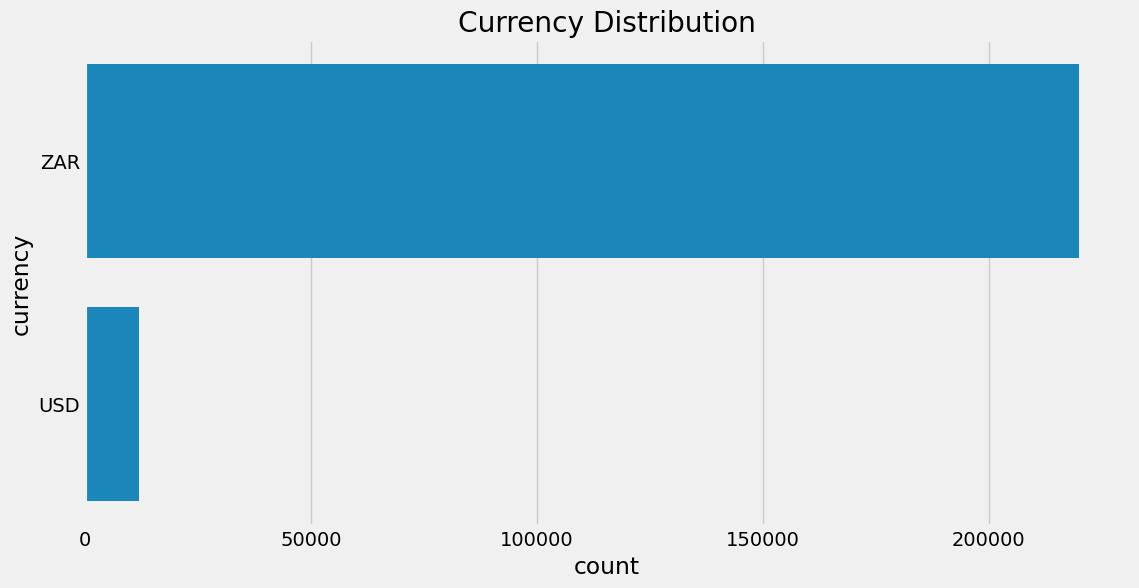

In [17]:
# Visualize the currency that is mostly used
plt.style.use('fivethirtyeight')
plt.figure(figsize=(12, 6))
sns.countplot(train['currency'])
plt.title('Currency Distribution')
plt.show();

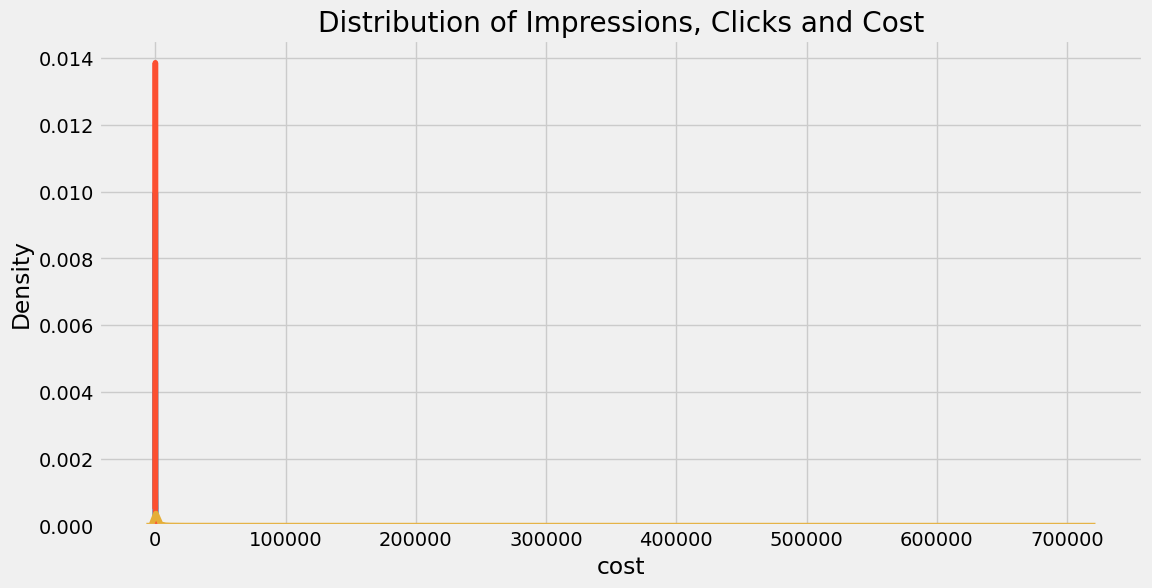

In [18]:
# Visualize the impressions, clicks and the cost
plt.figure(figsize=(12, 6))
sns.distplot(train['impressions'], hist=False, label='impressions')
sns.distplot(train['clicks'], hist=False, label='clicks')
sns.distplot(train['cost'], hist=False, label='cost')
plt.title('Distribution of Impressions, Clicks and Cost')
plt.show();

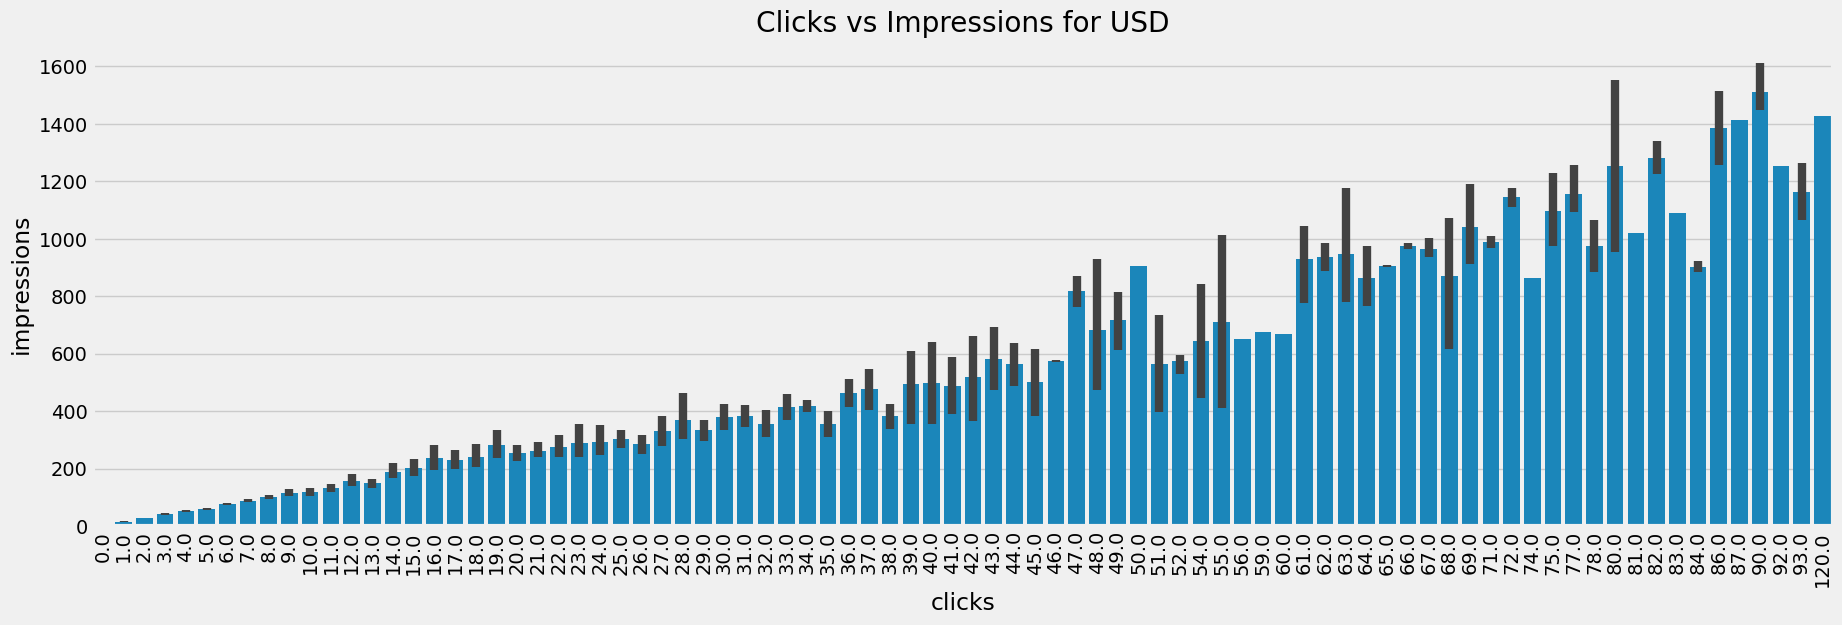

In [19]:
# The bar graph is congested, so let us plot a subset using currency for ZAR and USD
plt.figure(figsize=(20, 6))
sns.barplot(x='clicks', y='impressions', data=train[train['currency'].isin(['USD'])])
plt.title('Clicks vs Impressions for USD')
plt.xticks(rotation=90)
plt.show();

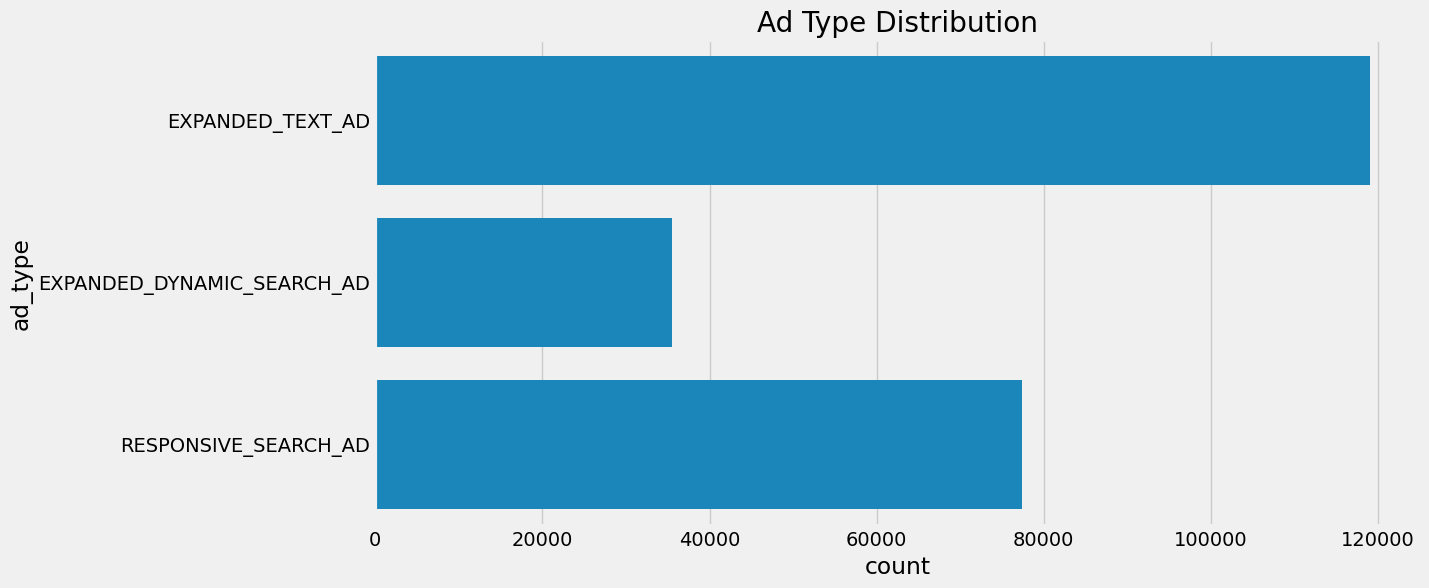

In [20]:
# We can also visualize the ad type
plt.figure(figsize=(12, 6))
sns.countplot(train['ad_type'])
plt.title('Ad Type Distribution')
plt.show();

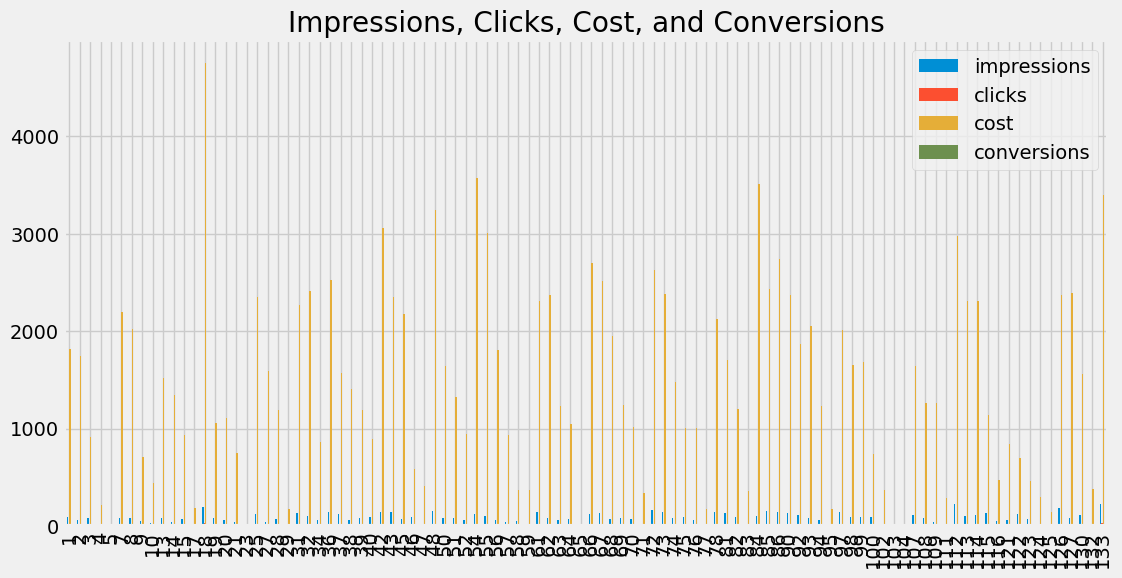

In [21]:
## Bar Plot for Impressions, Clicks, Cost, and Conversions a subset of 100 samples
data = train[['impressions', 'clicks', 'cost', 'conversions']].head(100)
data.plot(kind='bar', figsize=(12, 6))
plt.title('Impressions, Clicks, Cost, and Conversions')
plt.show();

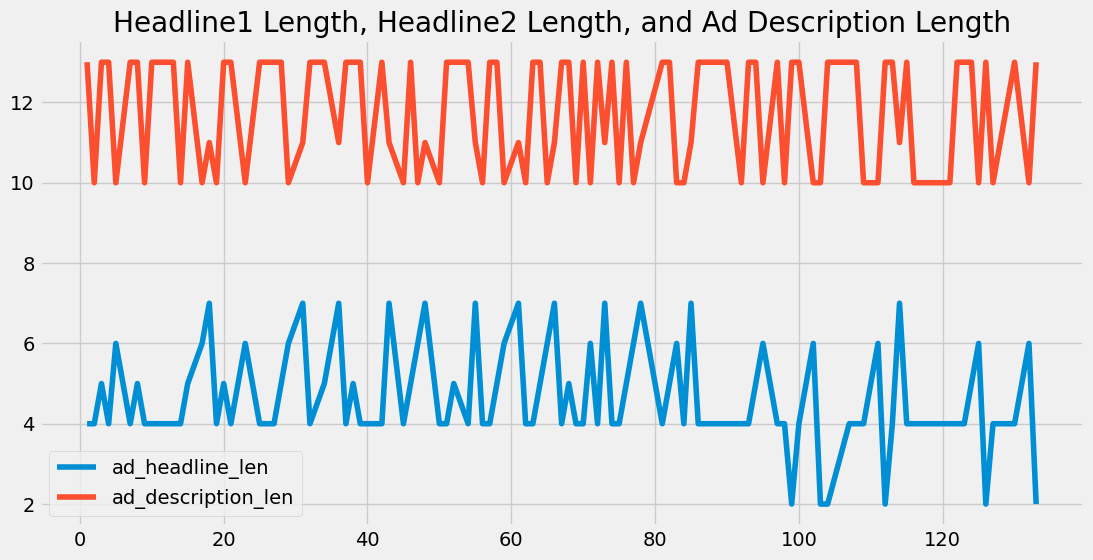

In [22]:
## Line Plot for Headline1 Length, Headline2 Length, and Ad Description Length
data = train[['ad_headline_len', 'ad_description_len']].head(100)
data.plot(kind='line', figsize=(12, 6))
plt.title('Headline1 Length, Headline2 Length, and Ad Description Length')
plt.show();

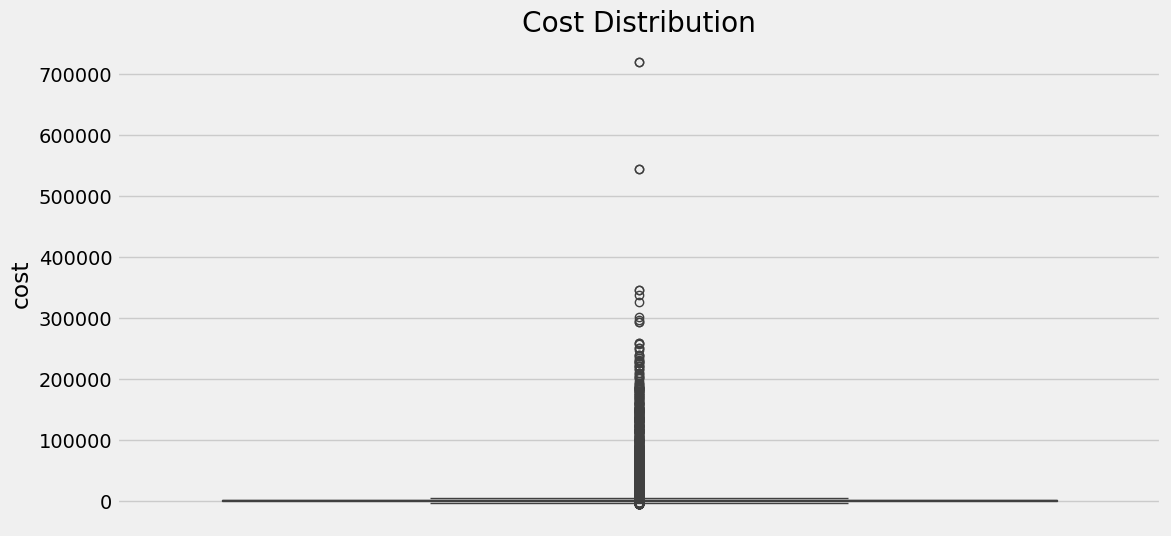

In [23]:
# Box plot of the cost distribution
plt.figure(figsize=(12, 6))
sns.boxplot(train['cost'])
plt.title('Cost Distribution')
plt.show();

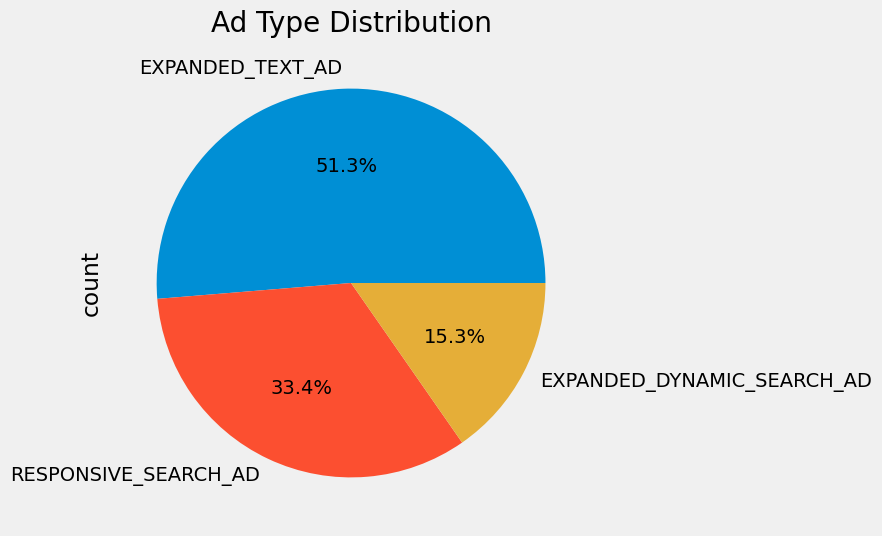

In [24]:
## Pie Chart for Ad Type Distribution
plt.figure(figsize=(12, 6))
train['ad_type'].value_counts().plot.pie(autopct='%1.1f%%')
plt.title('Ad Type Distribution')
plt.show();

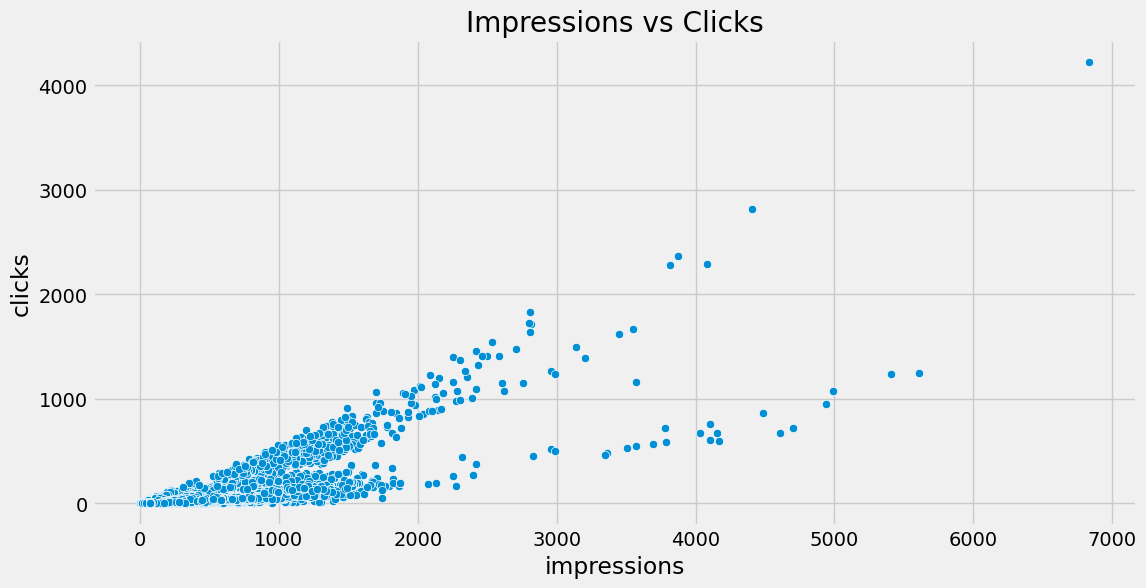

In [25]:
# Scatter Plot for Impressions vs. Clicks
plt.figure(figsize=(12, 6))
sns.scatterplot(x='impressions', y='clicks', data=train)
plt.title('Impressions vs Clicks')
plt.show();

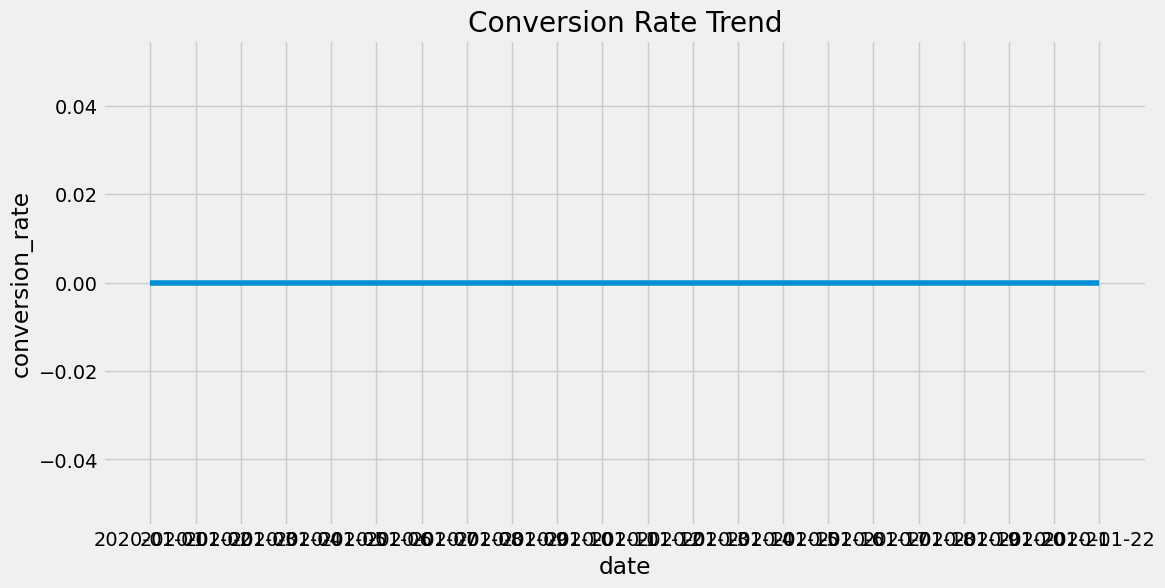

In [26]:
# Conversion Rate Trend
train['conversion_rate'] = train['conversions'] / train['clicks']

plt.figure(figsize=(12, 6))
sns.lineplot(x='date', y='conversion_rate', data=train.head(100))
plt.title('Conversion Rate Trend')
plt.show();

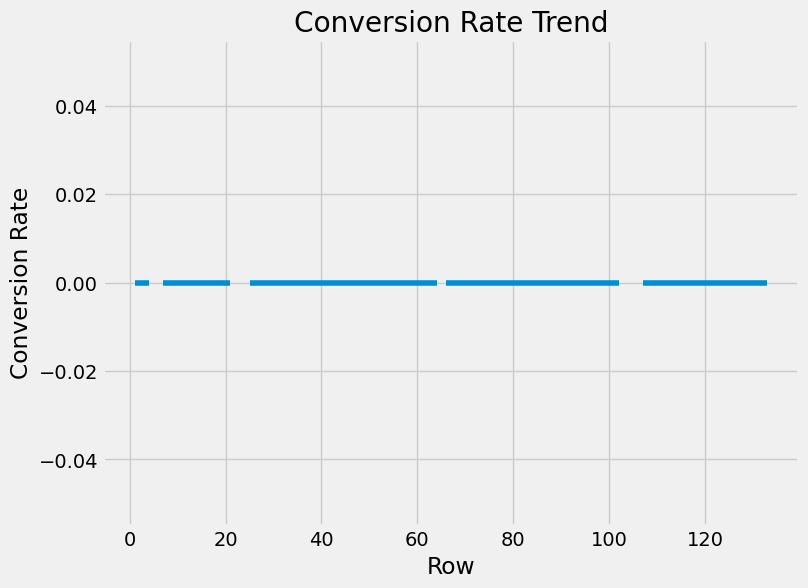

In [27]:
# Create the line plot
plt.figure(figsize=(8, 6))
train['conversion_rate'].head(100).plot(kind='line')
plt.title('Conversion Rate Trend')
plt.xlabel('Row')
plt.ylabel('Conversion Rate')
plt.show();

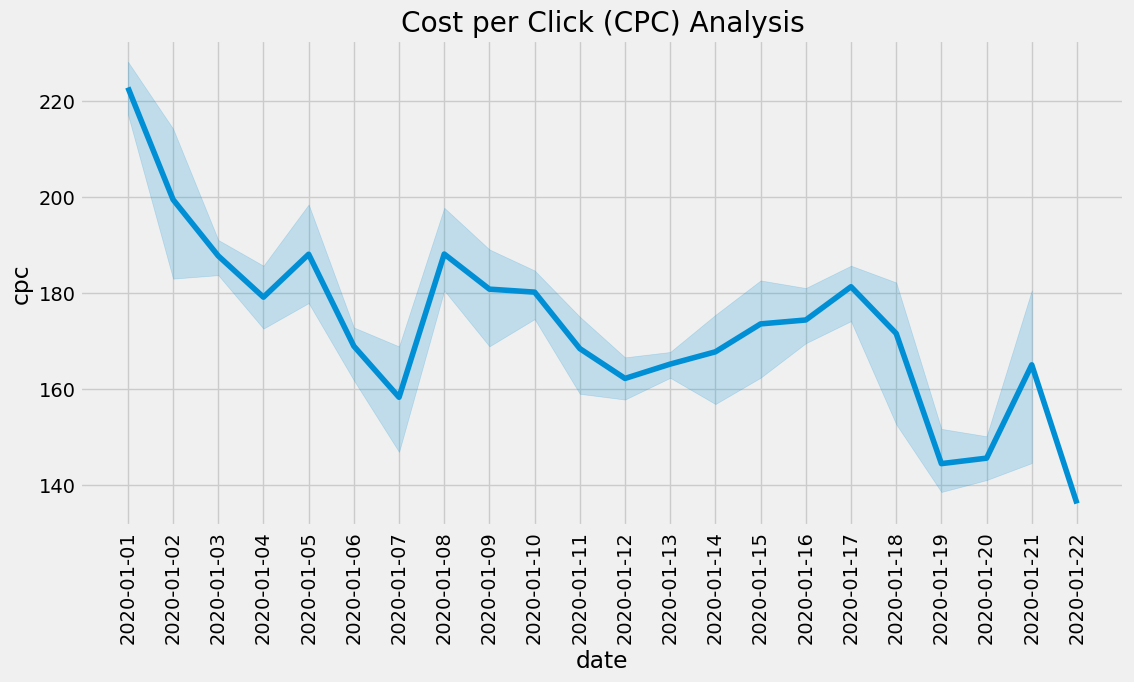

In [28]:
# Cost per Click (CPC) Analysis
train['cpc'] = train['cost'] / train['clicks']

plt.figure(figsize=(12, 6))
sns.lineplot(x='date', y='cpc', data=train.head(100))
plt.title('Cost per Click (CPC) Analysis')
plt.xticks(rotation=90)
plt.show();

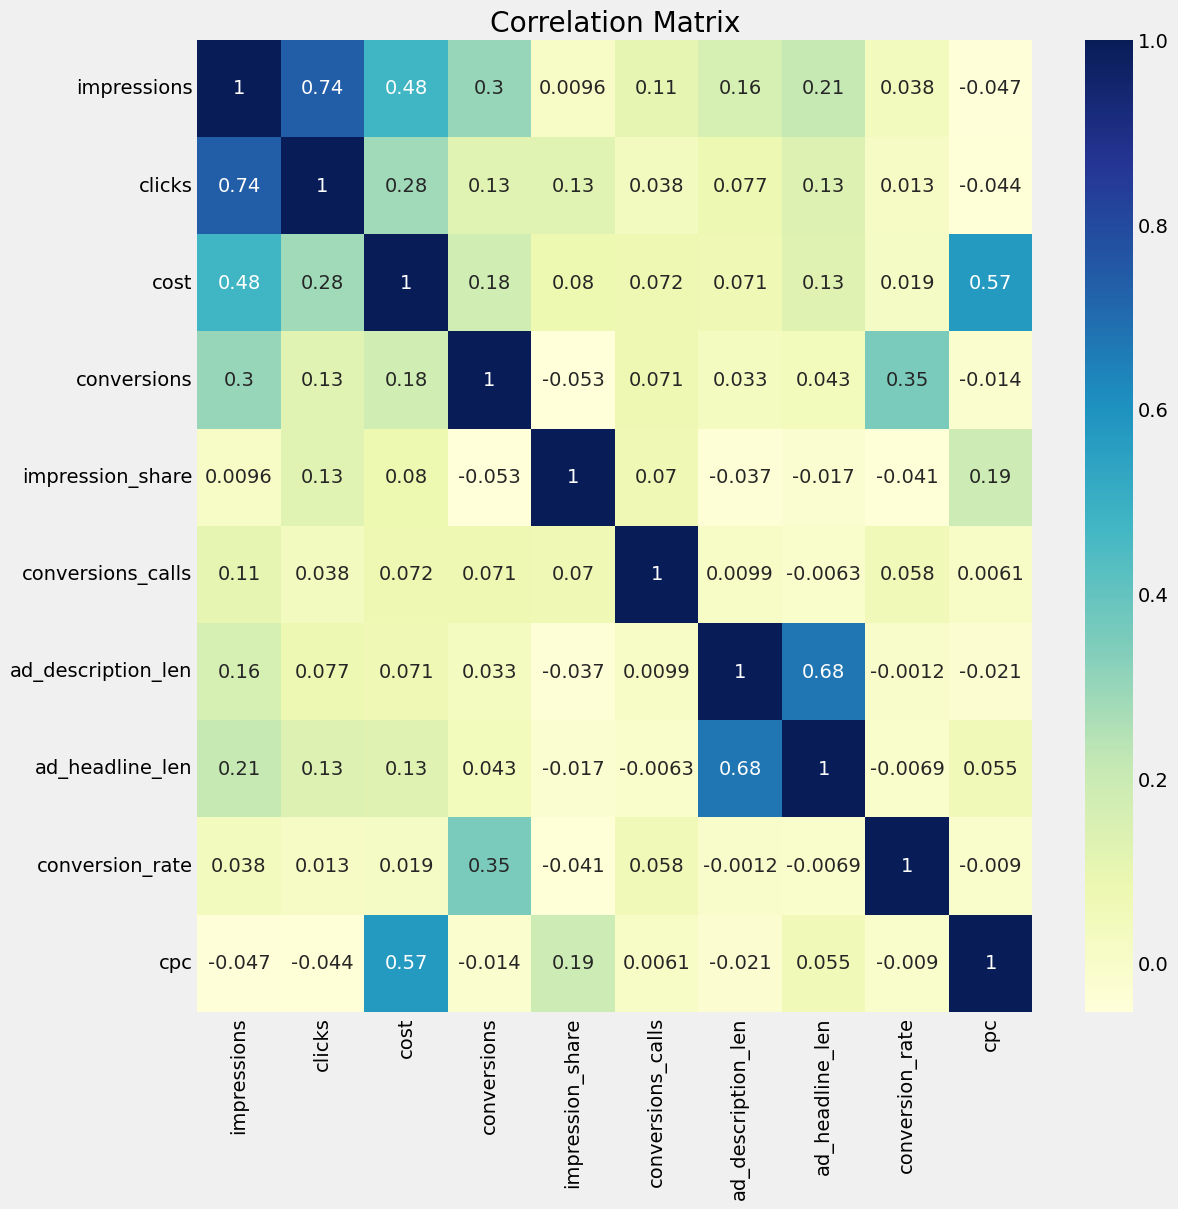

In [29]:
# Correlation Matrix (only for numerical columns)
numerical_columns = train.select_dtypes(include=[np.number]).columns
corr = train[numerical_columns].corr()
plt.figure(figsize=(12, 12))
sns.heatmap(corr, annot=True, cmap='YlGnBu')
plt.title('Correlation Matrix')
plt.show();

In [30]:
# Pick the top 5 correlated features
top_features = corr['clicks'].sort_values(ascending=False).head(6).index
top_features

Index(['clicks', 'impressions', 'cost', 'ad_headline_len', 'conversions',
       'impression_share'],
      dtype='object')

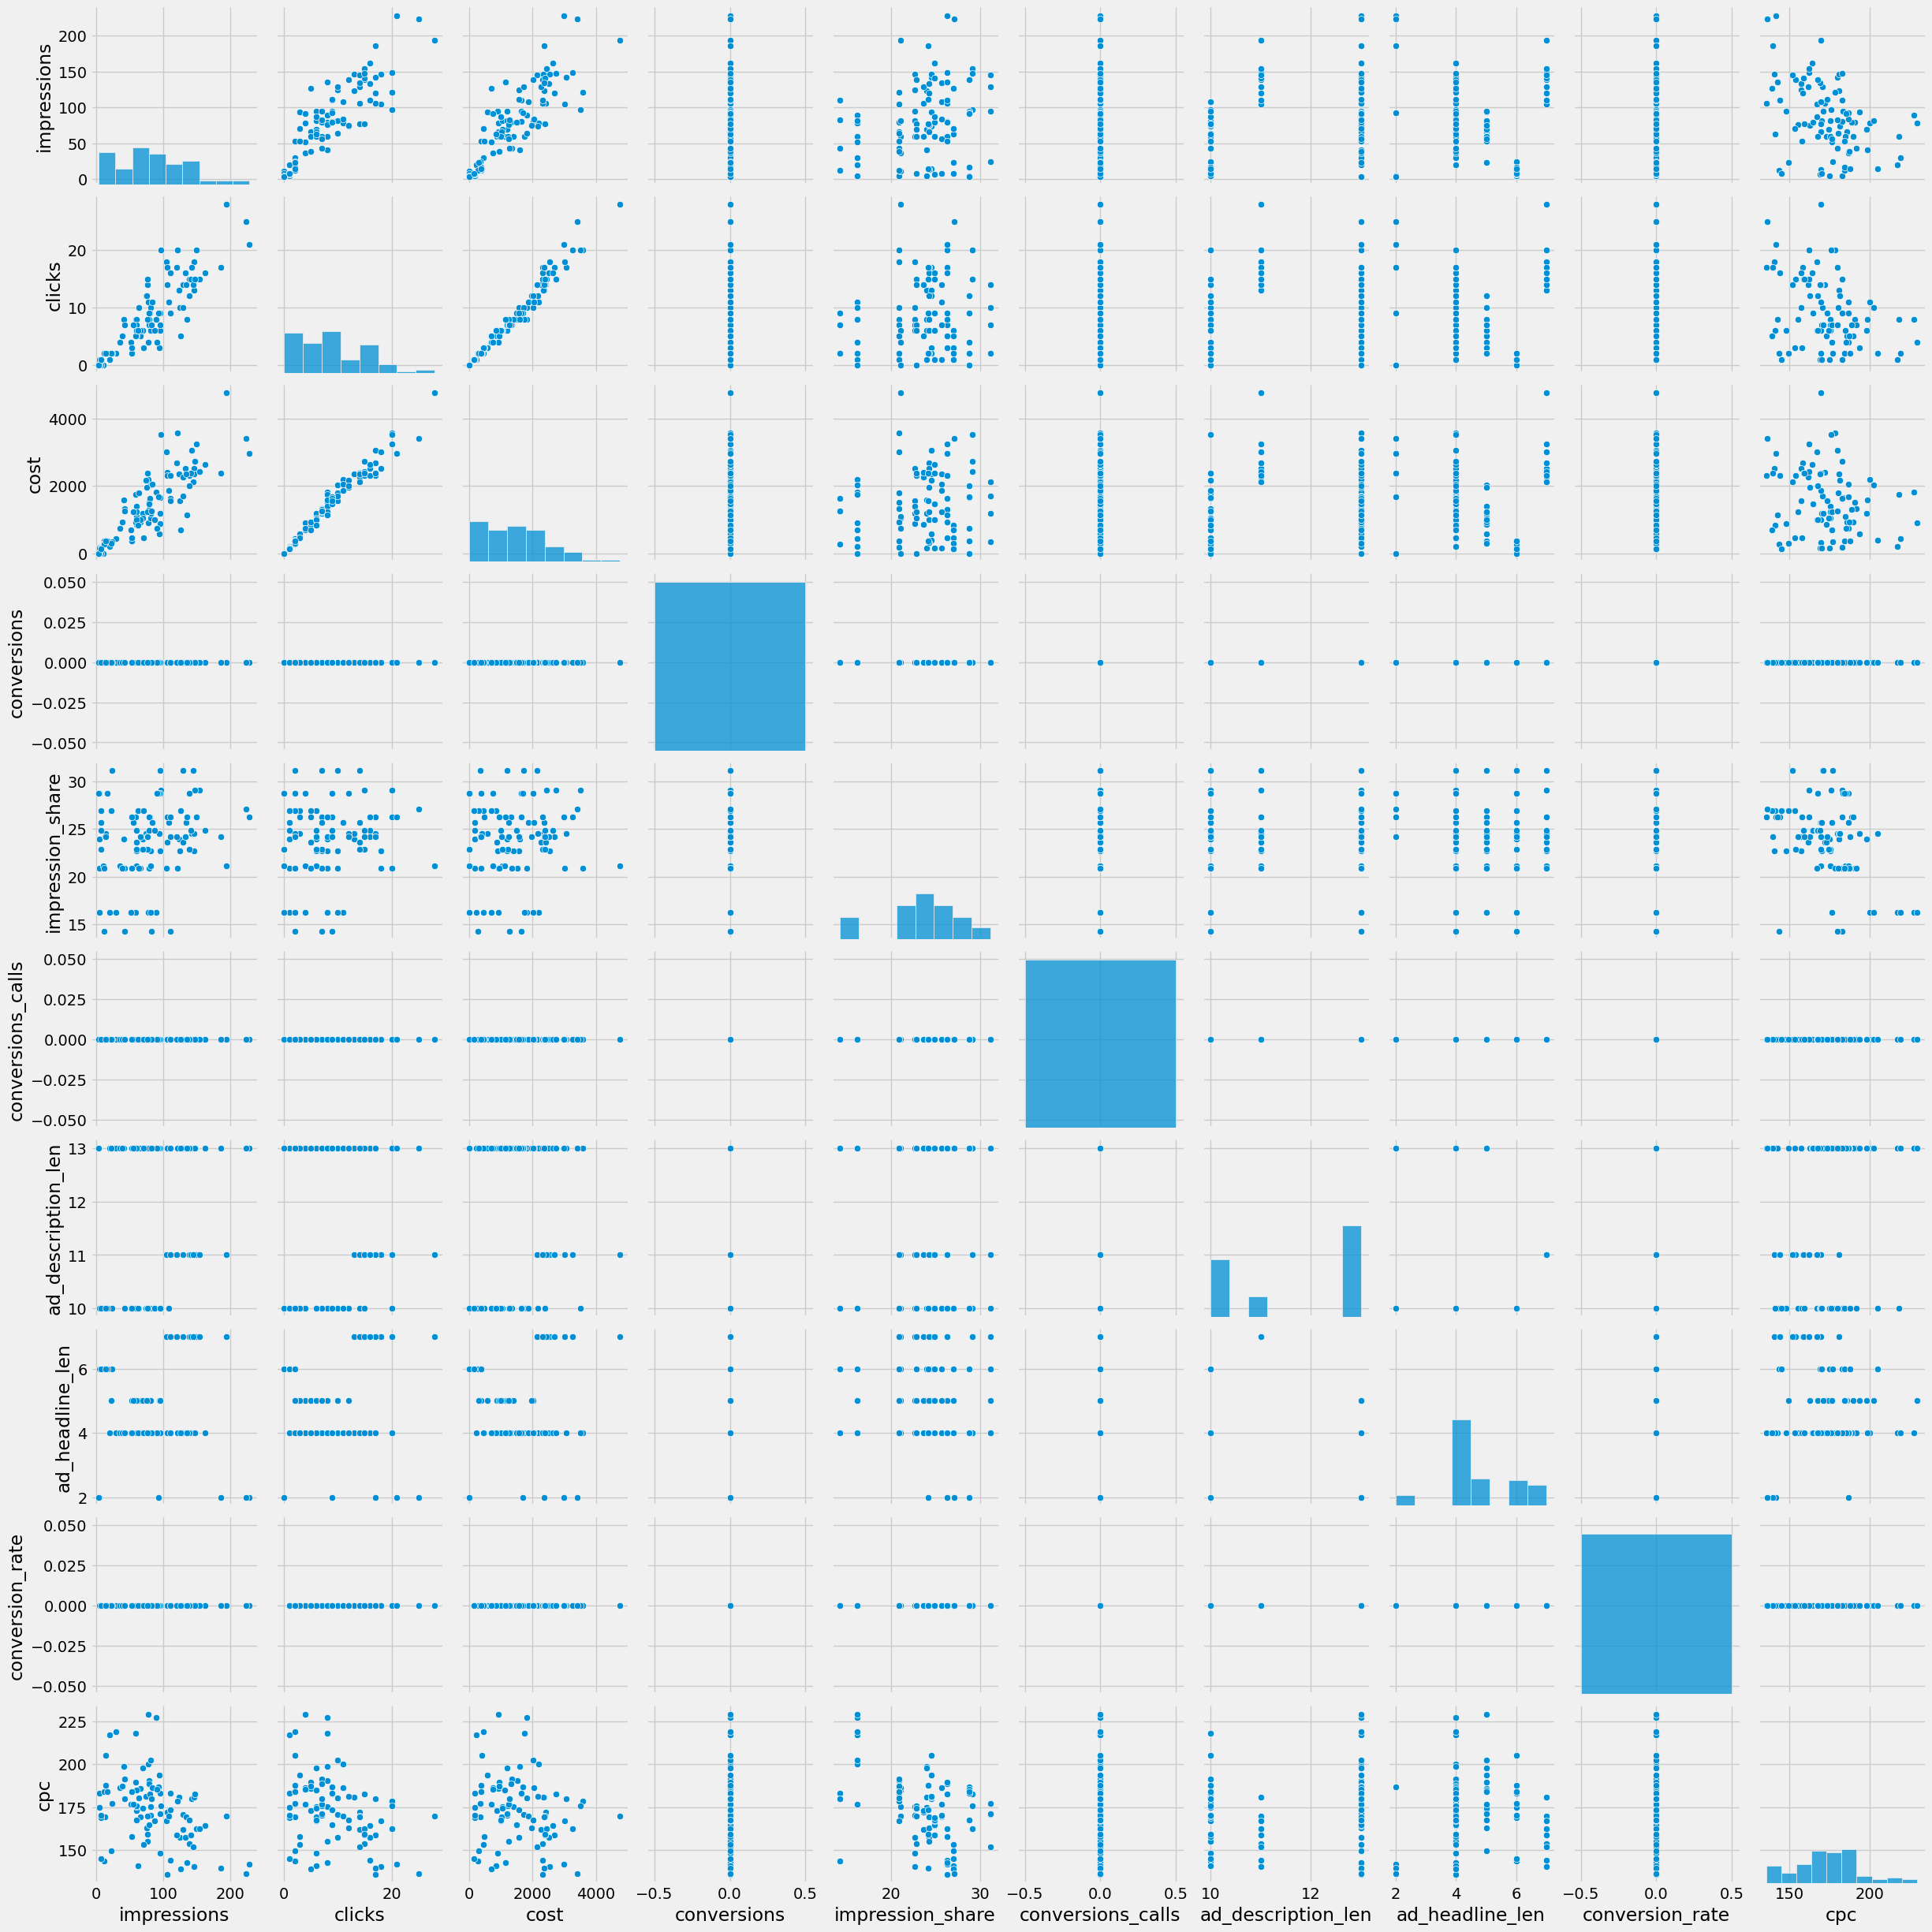

In [31]:
# Pairplot
sns.pairplot(train.head(100))
plt.show();

# Modelling

In [32]:
train[top_features].head()

,clicks,impressions,cost,ad_headline_len,conversions,impression_share
1,8.0,89.0,1817.0,4.0,0.0,16.279669
2,8.0,59.0,1743.0,4.0,0.0,16.279669
3,4.0,78.0,917.0,5.0,0.0,16.279669
4,1.0,20.0,217.0,4.0,0.0,16.279669
5,0.0,5.0,0.0,6.0,0.0,16.279669


In [34]:
# Now we can build our model
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

X = train[top_features].drop('clicks', axis=1)
y = train['clicks']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [35]:
X.head()

,impressions,cost,ad_headline_len,conversions,impression_share
1,89.0,1817.0,4.0,0.0,16.279669
2,59.0,1743.0,4.0,0.0,16.279669
3,78.0,917.0,5.0,0.0,16.279669
4,20.0,217.0,4.0,0.0,16.279669
5,5.0,0.0,6.0,0.0,16.279669


In [36]:
# Initialize the model
rf = RandomForestRegressor(n_estimators=100, random_state=42)

# Fit the model
rf.fit(X_train, y_train)

# Make predictions
y_pred = rf.predict(X_test)

# Evaluate the model
print(f'The root mean squared error is: {np.sqrt(mean_squared_error(y_test, y_pred))}')

The root mean squared error is: 6.376479242035963


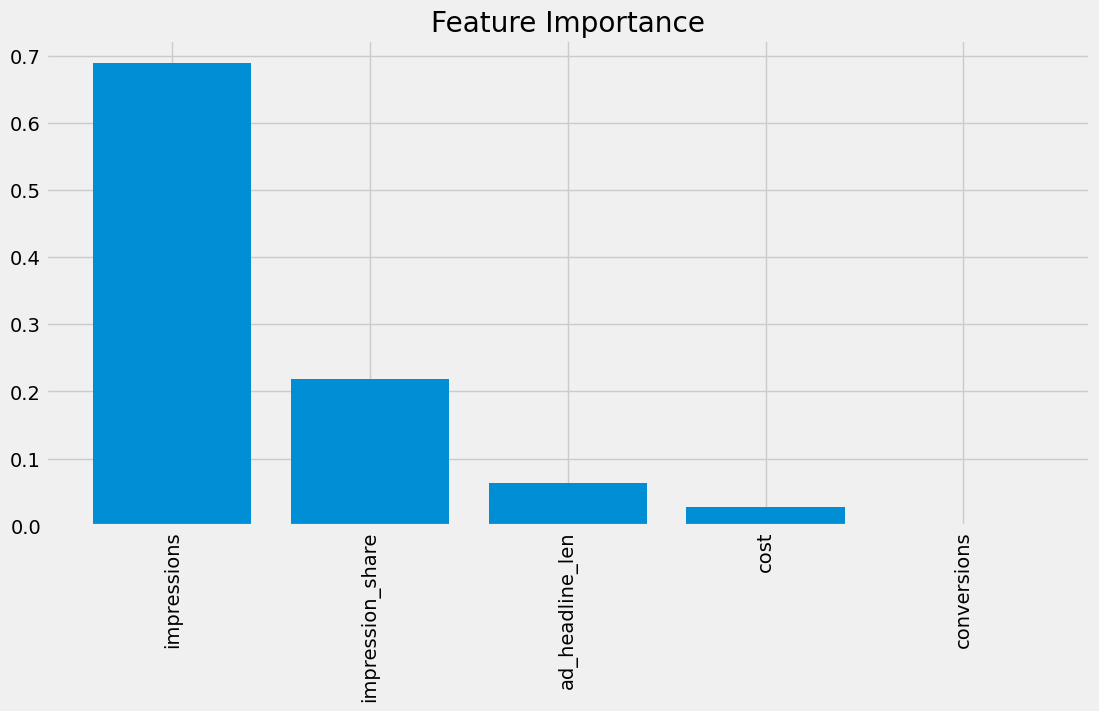

In [37]:
# Feature Importance
importances = rf.feature_importances_

# Sort the feature importance in descending order
indices = np.argsort(importances)[::-1]

# Rearrange the feature names so they match the sorted feature importance
names = [X.columns[i] for i in indices]

# Create the plot
plt.figure(figsize=(12, 6))
plt.bar(range(X.shape[1]), importances[indices])
plt.xticks(range(X.shape[1]), names, rotation=90)
plt.title('Feature Importance')
plt.show();

In [38]:
# XGBoost
!pip install -q xgboost
from xgboost import XGBRegressor

# Initialize the model
xgb = XGBRegressor(n_estimators=100, random_state=42)

# Fit the model
xgb.fit(X_train, y_train)

# Make predictions
y_pred = xgb.predict(X_test)

# Evaluate the model
print(f'The root mean squared error is: {np.sqrt(mean_squared_error(y_test, y_pred))}')


The root mean squared error is: 9.590992885458883


In [39]:
# Preprocess test set
test = pd.read_csv('Test.csv')
test.head()

,impressions,clicks,cost,conversions,ad_type,currency,ID,date,call_type,call_status,start_time,duration,end_time,display_location,impression_share,conversions_calls,headline1_len,headline2_len,ad_description_len
0,19.0,4.0,1058.703937,0.0,RESPONSIVE_SEARCH_AD,ZAR,ID_5ee74f25f865a8154966b412,2023-08-29,NaN,NaN,NaN,NaN,NaN,NaN,16.160352,0.0,5.0,3.0,15.0
1,18.0,3.0,5770.000000,0.0,RESPONSIVE_SEARCH_AD,ZAR,ID_617beb7403c1051f8a42b524,2023-05-15,NaN,NaN,NaN,NaN,NaN,NaN,36.628434,0.0,3.0,2.0,9.0
2,6.0,0.0,0.000000,0.0,EXPANDED_DYNAMIC_SEARCH_AD,ZAR,ID_5da86e71bf5dee4cf5047046,2021-03-15,NaN,NaN,NaN,NaN,NaN,NaN,22.700227,0.0,1.0,1.0,10.0
3,24.0,4.0,7341.000000,0.0,EXPANDED_TEXT_AD,ZAR,ID_60ffd129e838871b1754c836,2022-07-19,NaN,NaN,NaN,NaN,NaN,NaN,24.091778,0.0,2.0,3.0,10.0
4,8.0,0.0,0.000000,0.0,EXPANDED_TEXT_AD,ZAR,ID_608a6ad834a94a4eb8742899,2022-03-19,NaN,NaN,NaN,NaN,NaN,NaN,57.127500,0.0,3.0,3.0,14.0


In [40]:
# Drop missing values with more than 50% missing values
test = drop_missing_values(test, threshold=0.5*len(test))

# Impute impressions and clicks with the mean
test['impressions'] = test['impressions'].fillna(test['impressions'].mean())

# Impute clicks with the mean
test['clicks'] = test['clicks'].fillna(test['clicks'].mean())

# Impute cost with random values between the mean and standard deviation
mean = test['cost'].mean()
std = test['cost'].std()
null_count = test['cost'].isnull().sum()
random_values = np.random.randint(mean - std, mean + std, size=null_count)
test['cost'][np.isnan(test['cost'])] = random_values

# Impute conversions with the median
test['conversions'] = test['conversions'].fillna(test['conversions'].median())

# Impute conversion calls with the mean
test['conversions_calls'] = test['conversions_calls'].fillna(test['conversions_calls'].mean())

# Impute headline lengths with the median
test['headline1_len'] = test['headline1_len'].fillna(test['headline1_len'].median())

test['headline2_len'] = test['headline2_len'].fillna(test['headline2_len'].median())

# Merge the headline lengths to get the total headline length
test['ad_headline_len'] = test['headline1_len'] + test['headline2_len']

test.drop(['headline1_len', 'headline2_len'], axis=1, inplace=True)

# Impute ad description length with the median
test['ad_description_len'] = test['ad_description_len'].fillna(test['ad_description_len'].median())

# Impute ad type with the mode
test['ad_type'] = test['ad_type'].fillna(test['ad_type'].mode()[0])

# Impute currency with the mode
test['currency'] = test['currency'].fillna(test['currency'].mode()[0])

In [41]:
sample = pd.read_csv('SampleSubmission.csv')
sample.head()

,ID,clicks
0,ID_5da86e71bf5dee4cf5047046_2024_01_22,0
1,ID_5da86e71bf5dee4cf5047046_2024_01_29,0
2,ID_5e43c29e6279884e2827d894_2024_02_21,0
3,ID_5e43c29e6279884e2827d894_2024_02_28,0
4,ID_5e4e7b480e374330ee151305_2023_12_04,0


In [46]:
# Create a submission
predictions = xgb.predict(test[top_features.drop('clicks')])

sub = pd.DataFrame(
    {
        'ID': test['ID'],
        'clicks': predictions
    }
)

sub.to_csv('submission.csv', index=False)